# **Breast Cancer Detection using Tuned LightGBM and PCA**

This project applies machine learning to detect breast cancer using the Wisconsin Diagnostic Dataset, built into Scikit-Learn. We use Principal Component Analysis (PCA) for dimensionality reduction, and train a high performing model (LightGBM) to classify tumors as malignant or benign.

In [42]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import contextlib
import os
import sys

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

## Load and Prepare Data
_____________


In [5]:
data = load_breast_cancer()
type(data)

sklearn.utils._bunch.Bunch

In [6]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [7]:
X = data.data
y = data.target
feature_names = data.feature_names

In [8]:
# Creating a Pandas Dataframe
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

In [9]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Data Preprocessing and EDA
_______________________

In [10]:
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Correlation Heatmap

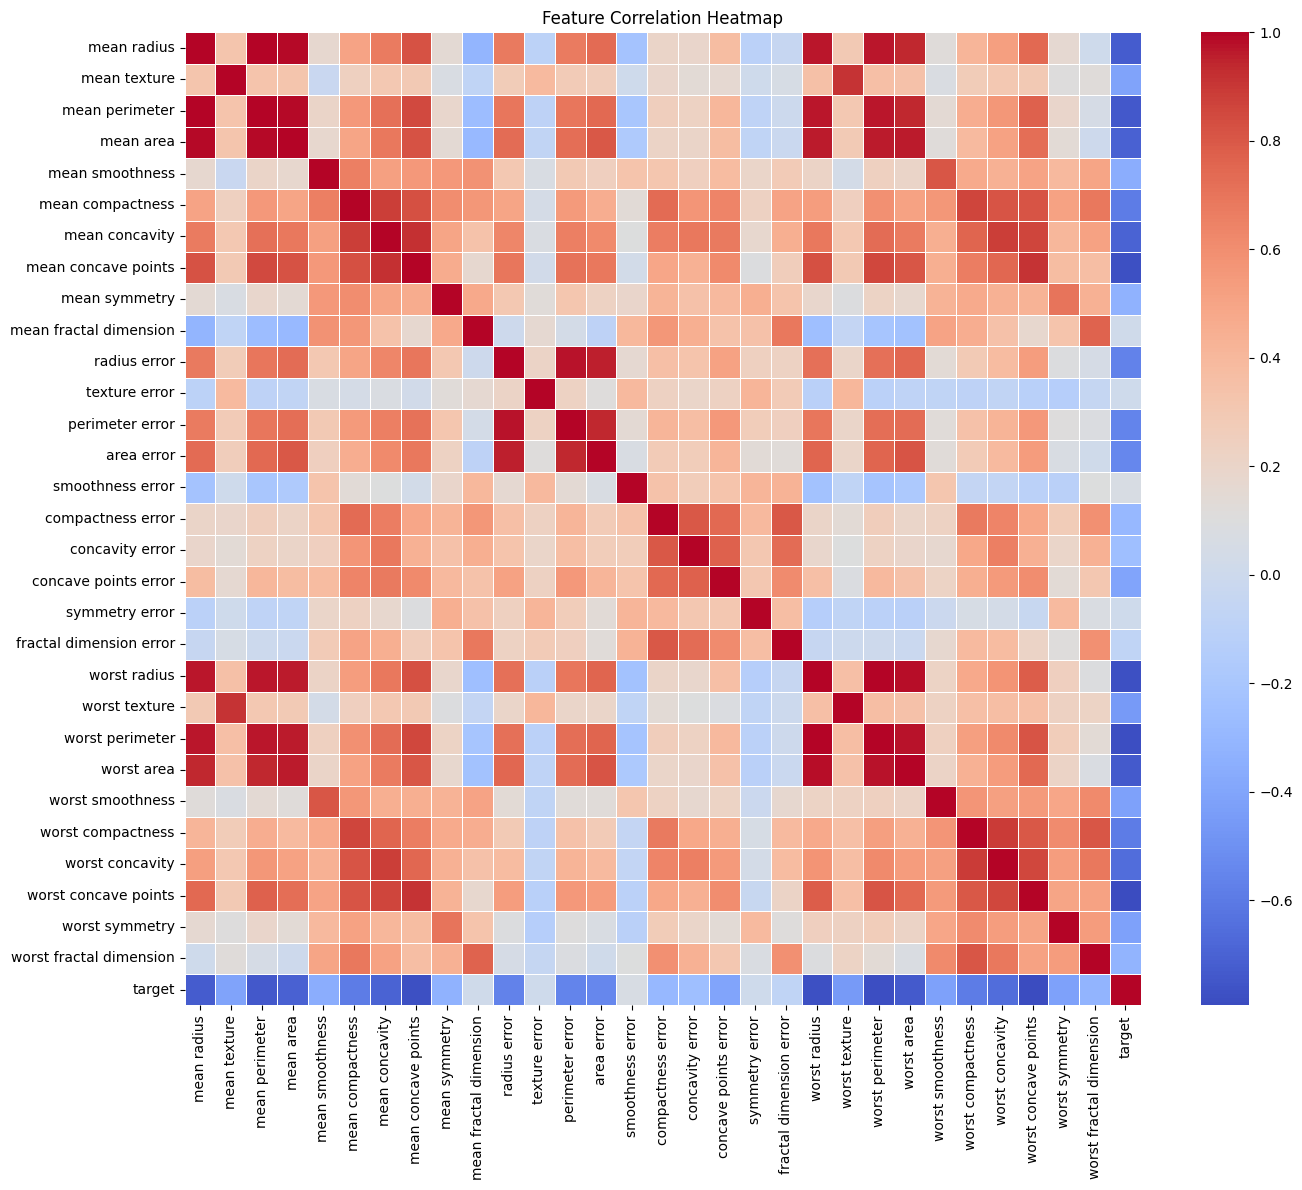

In [11]:
plt.figure(figsize=(14, 12))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()

### Pairplot for Selected Features

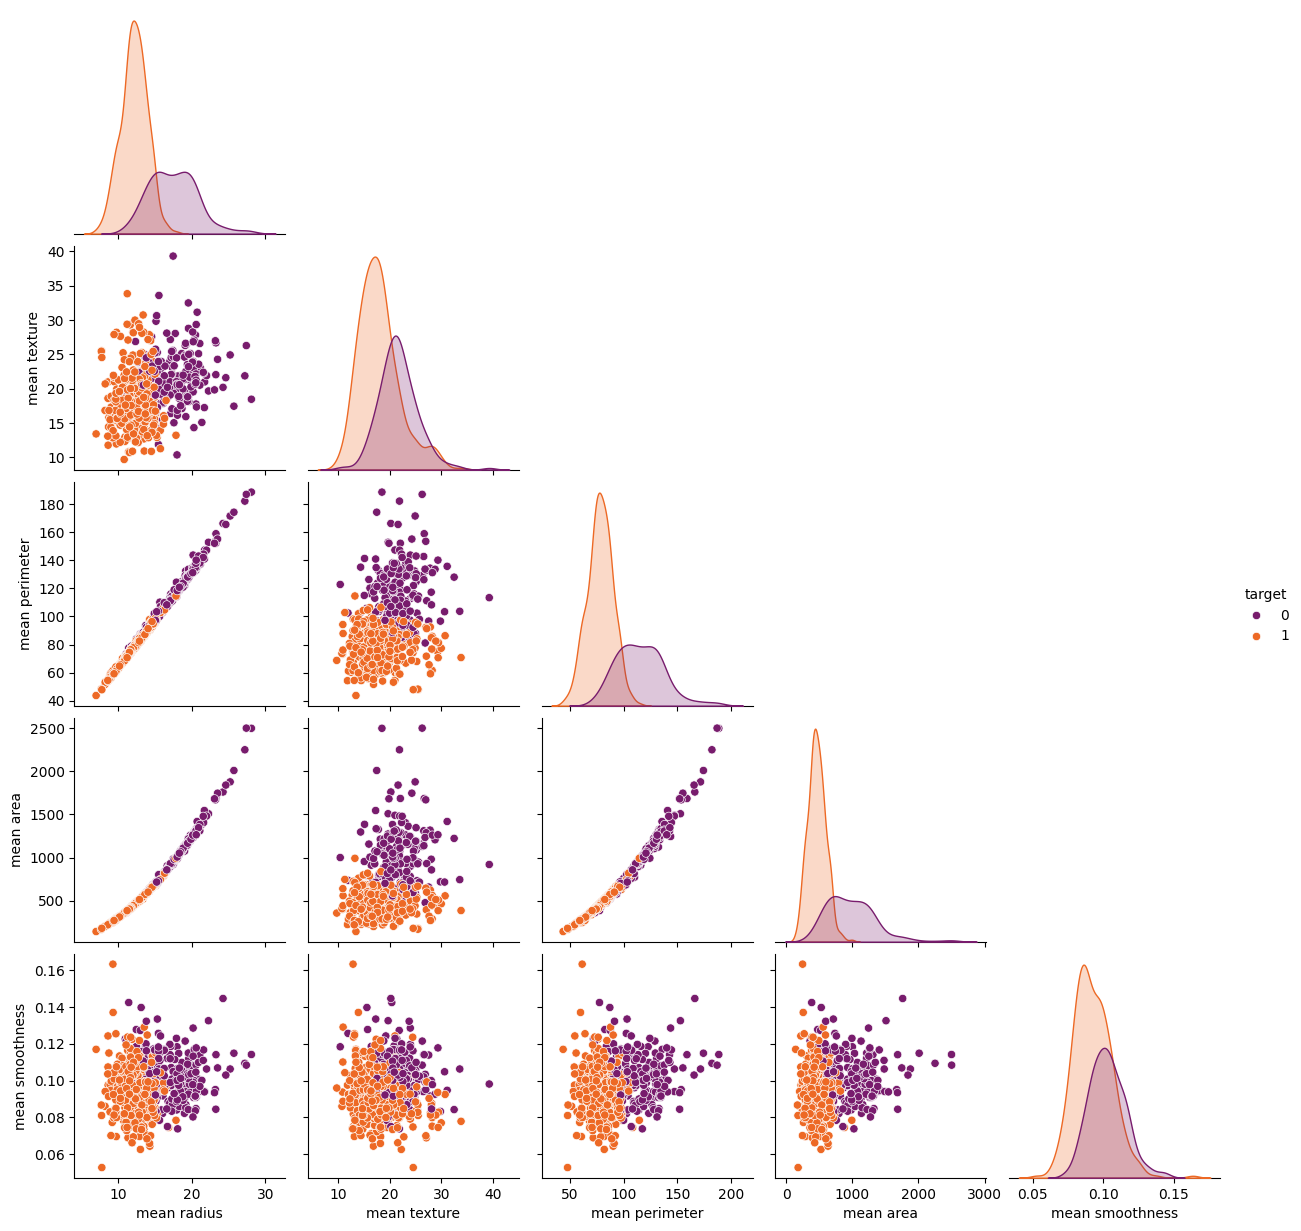

In [12]:
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'target']
sns.pairplot(df[selected_features], hue='target', palette='inferno', corner=True)

## Principal Component Analysis (PCA) for Visualization
______________________

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Text(0.5, 1.0, '2D PCA Projection of Breast Cancer Data')

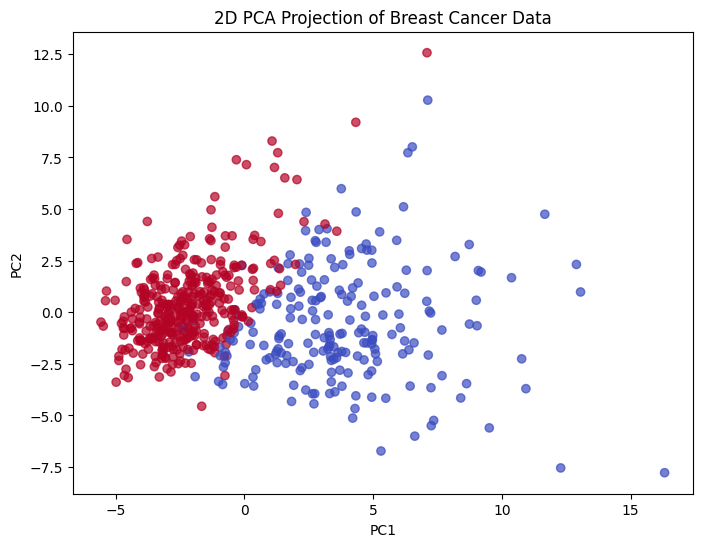

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Breast Cancer Data")

## Splitting Train and Test
_____________________

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Bayesian Hyperparameter Optimization with Optuna
________________________

In [23]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds)

In [33]:
# We need to make sure that  Optuna doesn't fill up the entire notebook with its logs, which it tends to do
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    study.optimize(objective, n_trials=50, show_progress_bar=True)
# Obtain the best params
best_params = study.best_trial.params
print("Best Hyperparameters:", best_params)

Best trial: 6. Best value: 0.979021: 100%|█████████████████████████████████████████████| 50/50 [00:08<00:00,  5.57it/s]

Best Hyperparameters: {'n_estimators': 475, 'learning_rate': 0.06119661695834652, 'max_depth': 3, 'num_leaves': 94, 'min_child_samples': 23, 'subsample': 0.5810233282559958, 'colsample_bytree': 0.5765318146443195, 'reg_alpha': 0.6424818973380652, 'reg_lambda': 0.0002996507756344334}


In [35]:
best_model = LGBMClassifier(**best_params, verbose=-1) # LightGBM tends to do the same, so we set verbose to -1 to avoid the logs
best_model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,94
,max_depth,3
,learning_rate,0.06119661695834652
,n_estimators,475
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,23


## Optuna Visualizations
______________________________________________

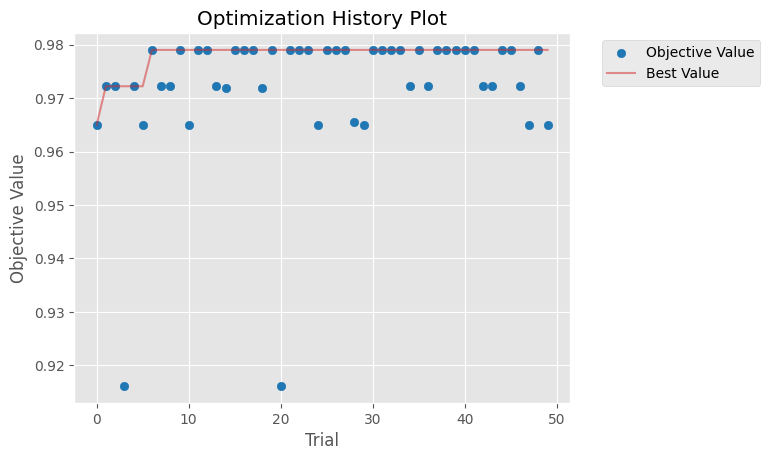

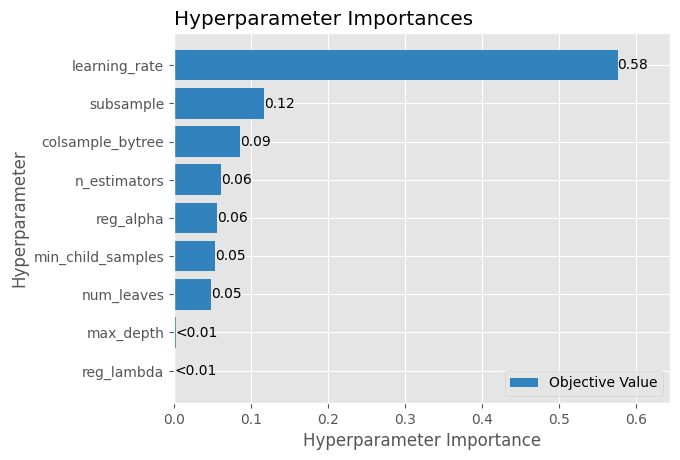

In [45]:
fig1 = plot_optimization_history(study)
fig2 = plot_param_importances(study)

## LightGBM Evaluation
______________________________

In [39]:
lgbm_preds = best_model.predict(X_test)
print("LightGBM F1 Score:", f1_score(y_test, lgbm_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, lgbm_preds))
print("Classification Report:\n", classification_report(y_test, lgbm_preds))

LightGBM F1 Score: 0.9790209790209791
Confusion Matrix:
 [[41  2]
 [ 1 70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## SHAP Feature Importances
___________________________________

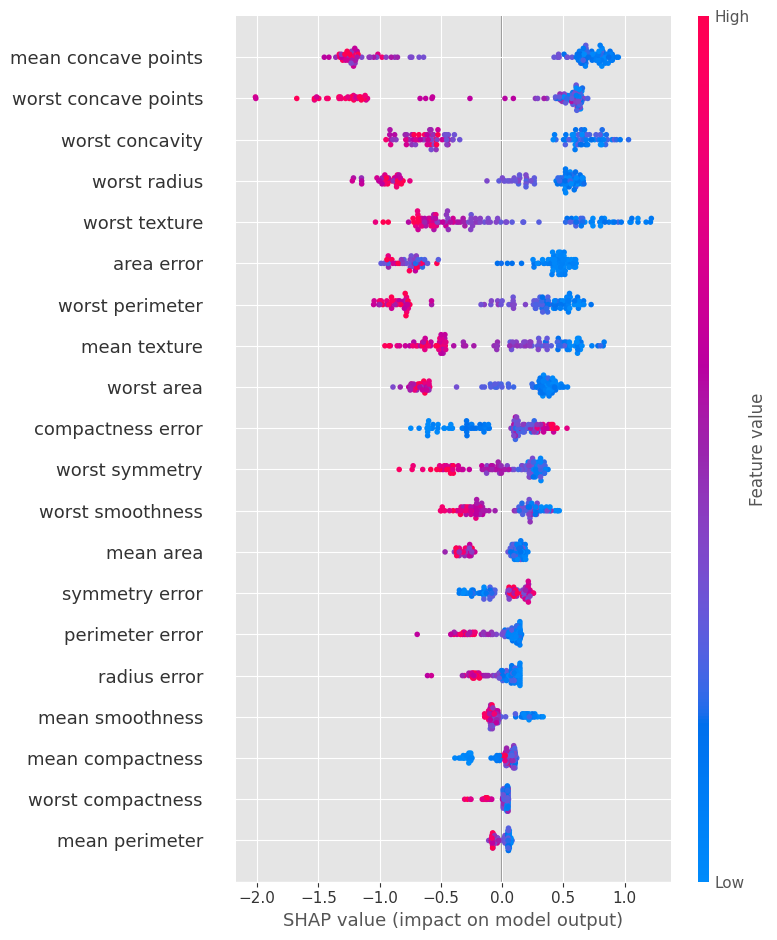

In [43]:
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.tight_layout()